In [80]:
!git clone https://github.com/PinaColadast/eth-capstone-treewater-deficit.git
!cd eth-capstone-treewater-deficit/ && git pull origin transformer_colab &&  git checkout transformer_colab
!ls

fatal: destination path 'eth-capstone-treewater-deficit' already exists and is not an empty directory.
remote: Enumerating objects: 5, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (1/1), done.
remote: Total 3 (delta 2), reused 3 (delta 2), pack-reused 0 (from 0)
Unpacking objects: 100% (3/3), 8.84 KiB | 283.00 KiB/s, done.
From https://github.com/PinaColadast/eth-capstone-treewater-deficit
 * branch            transformer_colab -> FETCH_HEAD
   577a5d4..6b99ce5  transformer_colab -> origin/transformer_colab
Updating 577a5d4..6b99ce5
Fast-forward
 04_Transformer_training.ipynb | 1447 ++++++++++++++++++++++++++++++++++-------
 1 file changed, 1215 insertions(+), 232 deletions(-)
M	src/treewater/__pycache__/__init__.cpython-312.pyc
M	src/treewater/__pycache__/utils.cpython-312.pyc
Already on 'transformer_colab'
Your branch is up to date with 'origin/transformer_colab'.
eth-capstone-treewater-deficit	sample_data


In [81]:
!cd eth-capstone-treewater-deficit/data/ && mkdir derived && cd derived && mkdir model_outputs

mkdir: cannot create directory ‘derived’: File exists


In [ ]:
import sys
sys.path.append('/content/eth-capstone-treewater-deficit/src')
# sys.path.append('/workspaces/eth-capstone-treewater-deficit/src')
import os
import glob 
import math

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import scipy as sc

import collections

from sklearn.metrics import  r2_score, mean_squared_error, mean_absolute_error, root_mean_squared_error
from sklearn.model_selection import train_test_split


import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
# PyTorch TensorBoard support
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime


from sklearn.preprocessing import StandardScaler
import treewater.utils as utils
# from treewater.utils import *

In [83]:
import importlib
importlib.reload(utils)

# check presence

print(hasattr(utils, "compute_recursive_predictions_fast_torch"))

True


In [84]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [85]:
# set global random seed
seed = 66666
torch.manual_seed(seed)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"  # suppress INFO + WARNING

In [86]:
# derived_path = "/home/renku/work/eth-capstone-treewater-deficit/data"
# data_dir = "/home/renku/work/eth-capstone-treewater-deficit/data/tstoy04"

derived_path = "/content/eth-capstone-treewater-deficit/data"
data_dir = "/content/eth-capstone-treewater-deficit/data/tstoy04"

model_output_dir = '/content/eth-capstone-treewater-deficit/data/derived/model_outputs/'

In [87]:
df_series_all = pd.read_csv(os.path.join(derived_path, "twd_tree_series_all.csv"))
twd_tree_series_sites = pd.read_csv(os.path.join(derived_path, "twd_tree_series_sites.csv"))

In [88]:
df_series_all.head(5)
# twd_tree_series_sites.head(10)

,ts,twd,pr,at,ws,dp,sr,lr,series,site_name,species,series_no,Wt,year,month,year_month
0,2020-01-01,0.000000,-4.967054e-09,0.684757,1.197186,-3.640214,62.291590,212.325577,series_03,Bachtel-Forest,Fagus sylvatica,1,NaN,2020,1,2020-01
1,2020-01-02,0.121408,-1.092752e-07,0.213088,1.312338,-4.036302,60.923900,219.828021,series_03,Bachtel-Forest,Fagus sylvatica,1,0.121408,2020,1,2020-01
2,2020-01-03,0.118271,1.285767e-01,2.009851,2.115951,-0.953911,55.859708,275.925156,series_03,Bachtel-Forest,Fagus sylvatica,1,-0.003137,2020,1,2020-01
3,2020-01-04,0.000000,9.927122e-02,1.573278,3.247398,0.721803,13.914832,311.878969,series_03,Bachtel-Forest,Fagus sylvatica,1,-0.118271,2020,1,2020-01
4,2020-01-05,0.000000,-1.986821e-08,-0.442240,2.159941,-4.094125,62.620516,216.038632,series_03,Bachtel-Forest,Fagus sylvatica,1,0.000000,2020,1,2020-01


## data preparation

In [92]:
# test if in the same day same site, temp and other features are the same

sites = df_series_all['site_name'].unique()
for site in sites:
    df_site = df_series_all.loc[df_series_all.site_name == site, ]
    series = df_site.series_no.unique()
    if len(series) >=2:
        series_1 = df_site.loc[df_site.series_no == series[0], ]
        series_2 = df_site.loc[df_site.series_no == series[1], ]
        merged = pd.merge(series_1, series_2, on='ts', suffixes=('_1', '_2'))
        temp_equal = all(merged['at_1'] == merged['at_2'])
        pr_equal = all(merged['pr_1'] == merged['pr_2'])
        dp_equal = all(merged['dp_1'] == merged['dp_2'])
        sr_equal = all(merged['sr_1'] == merged['sr_2'])
        if not (temp_equal and pr_equal and dp_equal and sr_equal):
            print(f"Data mismatch found in site {site} between series {series[0]} and {series[1]}")

# so far they are no mismatch found, all the other measurements are the same for different series in the same site


In [93]:
# twd_tree_series_sites

In [94]:
# Psudotsuga mnzisii", from site "Multi-Forest" in 2021, 2022 exluded
df_series_all = df_series_all.loc[~((df_series_all.species == "Psudotsuga mnzisii") & (df_series_all.site_name == "Multi-Forest") & (df_series_all.year.isin([2021, 2022]))), ]
df_series_all_median = df_series_all.groupby(['site_name', 'species', 'ts']).agg({'twd': 'median',  'year': 'first',
                                                                                 'pr': 'median', 'at': 'median', "ws": 'median', 'dp': 'median',
                                                                                 'sr': 'median', 'lr':'median'}).reset_index() 

df_series_all_median= df_series_all_median.merge(twd_tree_series_sites[['site_name', 'species', 'mch_elevation', "mch_easting",
                                                                        "mch_northing"]].drop_duplicates(), on=['site_name', 'species'], how='left')

In [95]:
# transform species to categorical variable - using ohe-hot encoding
# Get one hot encoding of columns B
one_hot = pd.get_dummies(df_series_all_median['species'],dtype=float)
# Drop column B as it is now encoded, hmm maybe not yet
df_series_all_features = df_series_all_median
# Join the encoded df
df_series_all_features = df_series_all_features.join(one_hot.iloc[: , 0:6])
# drop useless features 
df_series_features = df_series_all_features.drop(columns=['year'])

In [96]:
# create a dataframe with log2 transformed twd values
df_series_features_log2 = df_series_features.copy()
epsilon = 1
df_series_features_log2['twd'] = np.log2(epsilon+ df_series_features_log2['twd'])

(array([8368., 2837., 2769., 2630., 2114., 1456.,  740.,  628.,  271.,
         107.]),
 array([0.        , 0.27301828, 0.54603655, 0.81905483, 1.0920731 ,
        1.36509138, 1.63810966, 1.91112793, 2.18414621, 2.45716448,
        2.73018276]),
 <BarContainer object of 10 artists>)

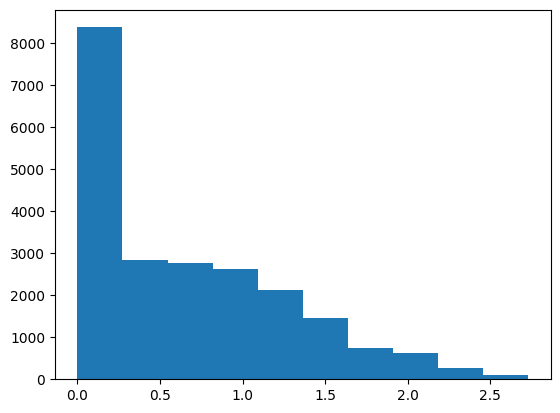

In [97]:
plt.hist(df_series_features_log2['twd'])

split the data into training and test set
 - train and test set split by an even distribution of sites? 
 - easting and northing recommended
 - if autoregressive with lag =13
    - label: twd_t
    - input feature: [twd_t-12, twd_t-11, ...twd_t-1, at_t-1, lt_t-1]? 
    - can i use at_t as input feature?


Normalize certain colums: 

- pr	at	ws	dp	sr	lr	mch_elevation	site_longitude	site_latitude
- if twd was treated as feature should we then standardize it when model is autoregressive? 
- should we normalize it before or after splitting by windows? - i guess really no harm either way 

In [114]:
# Configure features

config = utils.FeatureConfig()
lag_n =13 # use 7 and smaller model size 

# Autoregressive
# Split data
train_df_at, val_df_at, test_df_at = utils.create_training_test_set_optimized(
    df_series_features_log2,
    feature_window_size=lag_n,
    autoregressive=True
)

train_df_at, val_df_at, test_df_at = utils.standardize_dataset(
    train_df_at, val_df_at, test_df_at,
    config
)

# Create windows
train_X_ts_at, train_day_feat_X_at, train_static_X_ts_at,  train_y_at = utils.get_dataset_NN_torch(
    train_df_at,
    feature_window_size=lag_n,
    label_window_size = 1,
    autoregressive=True,
    shift = 1,
    config=config
)

val_X_ts_at, val_day_feat_X_at, val_static_X_ts_at, val_y_at = utils.get_dataset_NN_torch(
    val_df_at,
    feature_window_size=lag_n,
    label_window_size = 1,
    autoregressive=True,
    shift = 1,
    config=config
)





In [115]:
val_X_ts_at.shape

torch.Size([3260, 13, 7])

### build LSTM
- LSTM 
- RNN
- and perhaps try elastic net to improve ridgeregression model performance, and try gaussian regressor

In [116]:
batch_size = 128
lag_n = lag_n

### Autoregressive

In [117]:
# building datasets
batch_size = batch_size
train_X_ts_at, train_day_feat_X_at, train_static_X_ts_at,  train_y_at

# ensure tensors are on CPU for DataLoader
if train_X_ts_at.device.type == "cuda":
    train_X_ts_at = train_X_ts_at.cpu(); train_day_feat_X_at = train_day_feat_X_at.cpu(); train_static_X_ts_at = train_static_X_ts_at.cpu(); train_y_at = train_y_at.cpu()
train_ds = TensorDataset(train_X_ts_at, train_day_feat_X_at, train_static_X_ts_at, train_y_at)
train_loader = DataLoader(train_ds,
                          batch_size=batch_size,
                          shuffle=True,
                          pin_memory=torch.cuda.is_available(),
                          num_workers=4)

# validation dataset

if val_X_ts_at.device.type == "cuda":
    val_X_ts_at = val_X_ts_at.cpu(); val_day_feat_X_at = val_day_feat_X_at.cpu(); val_static_X_ts_at = val_static_X_ts_at.cpu(); val_y_at = val_y_at.cpu()

val_loader = DataLoader(TensorDataset(val_X_ts_at, val_day_feat_X_at, val_static_X_ts_at, val_y_at),
                        batch_size=batch_size,
                        shuffle=False,
                        pin_memory=torch.cuda.is_available(),
                        num_workers=2)


# create cross validate datasets 
# create cross validation dataframes 

train_val_datasets_at = utils.cross_validate_datasets(train_df_at, n_splits=4, feature_window_size=lag_n, config=config)

# build tf.data.Dataset for each fold
cv_train_val_ds_at = []
for train_cv_df, val_cv_df in train_val_datasets_at:
    X_tr, Xd_tr, Xs_tr, y_tr = utils.get_dataset_NN_torch(train_cv_df, feature_window_size=lag_n, autoregressive=True, config=config)
    if X_tr.device.type == "cuda":
        X_tr = X_tr.cpu(); Xd_tr = Xd_tr.cpu(); Xs_tr = Xs_tr.cpu(); y_tr = y_tr.cpu()
    tr_loader = DataLoader(TensorDataset(X_tr, Xd_tr, Xs_tr, y_tr),
                           batch_size=batch_size, shuffle=True, pin_memory=torch.cuda.is_available())

    X_va, Xd_va, Xs_va, y_va = utils.get_dataset_NN_torch(val_cv_df, feature_window_size=lag_n, autoregressive=True, config=config)
    if X_va.device.type == "cuda":
        X_va = X_va.cpu(); Xd_va = Xd_va.cpu(); Xs_va = Xs_va.cpu(); y_va = y_va.cpu()
    va_loader = DataLoader(TensorDataset(X_va, Xd_va, Xs_va, y_va),
                           batch_size=batch_size, shuffle=False, pin_memory=torch.cuda.is_available())

    cv_train_val_ds_at .append((tr_loader, va_loader))


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


### Build transformer architecture

In [118]:

class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, max_len: int = 64):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        pos = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(pos * div)
        pe[:, 1::2] = torch.cos(pos * div)
        self.register_buffer("pe", pe)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x: (B, T, d_model)
        T = x.size(1)
        return x + self.pe[:T].unsqueeze(0)

class EncoderOnlyForecast(nn.Module):
    """
    Uses TransformerEncoderLayer + TransformerEncoder as the core architecture.
    Inputs:
      past_dynamic: (B, T, n_dyn)
      current_day_exog: (B, n_day)
      static: (B, n_static)
    Output:
      next-day twd: (B,)
    """
    def __init__(
        self,
        n_dyn: int,
        n_day: int,
        n_static: int,
        T: int = 13,
        d_model: int = 64,
        nhead: int = 4,
        num_layers: int = 3,
        dim_feedforward: int = 32,
        dropout: float = 0.1,
        out_nonneg: bool = False,
    ):
        super().__init__()
        self.T = T
        self.out_nonneg = out_nonneg

        # project dynamic features -> d_model
        self.in_proj = nn.Linear(n_dyn, d_model)
        self.pos = PositionalEncoding(d_model, max_len=max(T, 64))

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            activation="relu",
            batch_first=True,  # IMPORTANT: we use (B, T, C)
            norm_first=True,
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # combine with day exog + static
        self.day_mlp = nn.Sequential(
            nn.Linear(n_day, 8),
            nn.ReLU(),
            nn.Dropout(dropout),
        )
        self.static_mlp = nn.Sequential(
            nn.Linear(n_static, 8),
            nn.ReLU(),
            nn.Dropout(dropout),
        )

        self.head = nn.Sequential(
            nn.Linear(d_model + 8 + 8, 64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, 1),
        )

    def forward(self, past_dynamic, current_day_exog, static):
        # past_dynamic: (B, T, n_dyn)
        x = self.in_proj(past_dynamic)   # (B, T, d_model)
        x = self.pos(x)
        x = self.encoder(x)              # (B, T, d_model)

        # pool: last token (works well for fixed window)
        x_seq = x[:, -1, :]              # (B, d_model)

        x_day = self.day_mlp(current_day_exog)
        x_stat = self.static_mlp(static)

        z = torch.cat([x_seq, x_day, x_stat], dim=-1)
        y = self.head(z).squeeze(-1)

        if self.out_nonneg:
            y = F.linear(y) # using linear to allow negative outputs for log2 twd

        return y


### set up cross validation

In [119]:
# example: model_factory = lambda: EncoderOnlyForecast(...).to(device)

def train_one_epoch(model, epoch_index, train_loader, loss_fn, optimizer, device=None, log_every=100):
    device = device or next(model.parameters()).device
    running_loss = 0.0
    sse = 0.0
    n_samples = 0
    n_batches = 0

    model.train()
    for i, batch in enumerate(train_loader):
        X_dyn, X_day, X_static, labels = batch
        X_dyn = X_dyn.to(device); X_day = X_day.to(device); X_static = X_static.to(device); labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(X_dyn, X_day, X_static)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += float(loss.item())
        batch_sse = float(F.mse_loss(outputs, labels, reduction='sum').item())
        sse += batch_sse
        n_samples += labels.numel()
        n_batches += 1

        if (i + 1) % log_every == 0:
            print(f'  batch {i+1} loss: {running_loss / n_batches:.4f}')

    avg_batch_loss = running_loss / n_batches if n_batches > 0 else float("nan")
    train_rmse = math.sqrt(sse / n_samples) if n_samples > 0 else float("nan")
    return avg_batch_loss, train_rmse

def train_transformer(model, train_loader, val_loader, loss_fn, optimizer, n_epochs=50, device=None):
    device = device or next(model.parameters()).device
    best_val_rmse = float("inf")
    best_model_state = None
    history = {"train_loss": [], "val_loss": [], "train_rmse": [], "val_rmse": []}

    model.to(device)
    for epoch in range(n_epochs):
        print(f'Epoch {epoch + 1}/{n_epochs}')
        train_loss, train_rmse = train_one_epoch(model, epoch, train_loader, loss_fn, optimizer, device=device)
        print(f'  Train Loss: {train_loss:.4f}, Train RMSE: {train_rmse:.4f}')

        # validation
        model.eval()
        val_sse = 0.0
        val_batches = 0
        val_n = 0
        val_loss_sum = 0.0
        with torch.no_grad():
            for batch in val_loader:
                X_dyn, X_day, X_static, labels = batch
                X_dyn = X_dyn.to(device); X_day = X_day.to(device); X_static = X_static.to(device); labels = labels.to(device)
                outputs = model(X_dyn, X_day, X_static)
                vloss = loss_fn(outputs, labels)
                val_loss_sum += float(vloss.item())
                val_sse += float(F.mse_loss(outputs, labels, reduction='sum').item())
                val_n += labels.numel()
                val_batches += 1

        avg_vloss = val_loss_sum / val_batches if val_batches > 0 else float("nan")
        val_rmse = math.sqrt(val_sse / val_n) if val_n > 0 else float("nan")
        print(f'  Validation Loss: {avg_vloss:.4f}, Validation RMSE: {val_rmse:.4f}')

        history["train_loss"].append(train_loss)
        history["train_rmse"].append(train_rmse)
        history["val_loss"].append(avg_vloss)
        history["val_rmse"].append(val_rmse)

        if val_rmse < best_val_rmse:
            best_val_rmse = val_rmse
            best_model_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}

    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    return model, history

def cross_validate_transformer(model_factory, cv_train_val_ds_at, train_val_datasets_at, loss_fn, optimizer_class, lr=1e-3/2, n_epochs=50, device=None,
                               if_log = False):
    rmses_cv_at = []
    rmses_cv_1d_at = []
    r2s_cv_1d_at = []
    r2s_cv_at = []
    y_preds_cv_at = []
    y_trues_cv_at = []
    historys_cv_at = []

    for fold, (train_loader, val_loader) in enumerate(cv_train_val_ds_at):
        print(f'Starting fold {fold + 1}/{len(cv_train_val_ds_at)}')
        model_fold = model_factory().to(device) if device else model_factory()
        optimizer = optimizer_class(model_fold.parameters(), lr=lr)

        model_fold, history = train_transformer(model_fold, train_loader, val_loader, loss_fn, optimizer, n_epochs=n_epochs)

        model_fold.eval()
        val_y_cv_1d_at = []
        val_preds_cv_1d_at = []
        with torch.no_grad():
            for batch in val_loader:
                X_dyn, X_day, X_static, labels = batch
                X_dyn = X_dyn.to(device); X_day = X_day.to(device); X_static = X_static.to(device)
                outputs = model_fold(X_dyn, X_day, X_static)
                val_y_cv_1d_at.append(labels.cpu().numpy())
                val_preds_cv_1d_at.append(outputs.cpu().numpy())

        val_y_cv_1d_at = np.concatenate(val_y_cv_1d_at, axis=0)
        val_preds_cv_1d_at = np.concatenate(val_preds_cv_1d_at, axis=0)
        

        # recursive evaluation (ensure compute_recursive_predictions_fast_torch expects a model on CPU or device you pass)
        val_cv_df_at = train_val_datasets_at[fold][1]
        val_pred_recursive_at, val_true_recursive_at = utils.compute_recursive_predictions_fast_torch(
            model_fold, val_cv_df_at, feature_window_size=lag_n, label_window_size=1, shift=1,
            config=config, batch_size=batch_size)

        if if_log == True:
          val_pred_recursive_at = utils.clip_and_inverse_log2_transform(val_pred_recursive_at)
          val_true_recursive_at = np.exp2(val_true_recursive_at)-1
          
          val_preds_cv_1d_at = utils.clip_and_inverse_log2_transform(val_preds_cv_1d_at)
          val_y_cv_1d_at = np.exp2(val_y_cv_1d_at)-1

        val_rmse_1day_at = root_mean_squared_error(val_y_cv_1d_at, val_preds_cv_1d_at)
        rmse_recursive_at = root_mean_squared_error(val_true_recursive_at, val_pred_recursive_at)
        r2_1day_at = r2_score(val_y_cv_1d_at, val_preds_cv_1d_at)
        r2_recursive_at = r2_score(val_true_recursive_at, val_pred_recursive_at)

        rmses_cv_at.append(rmse_recursive_at)
        rmses_cv_1d_at.append(val_rmse_1day_at)
        r2s_cv_1d_at.append(r2_1day_at)
        r2s_cv_at.append(r2_recursive_at)
        y_preds_cv_at.append(val_pred_recursive_at)
        y_trues_cv_at.append(val_true_recursive_at)
        historys_cv_at.append(history)

    return rmses_cv_at, rmses_cv_1d_at, r2s_cv_1d_at, r2s_cv_at, y_preds_cv_at, y_trues_cv_at, historys_cv_at

In [120]:
model_factory = lambda : EncoderOnlyForecast(
            n_dyn=train_X_ts_at.shape[2],
            n_day=train_day_feat_X_at.shape[1],
            n_static=train_static_X_ts_at.shape[1],
            T=lag_n,
            d_model=32,
            nhead=4,
            num_layers=3,
            dim_feedforward=32,
            dropout=0.1,
            out_nonneg=False
        ).to(device)

# build a training loop

loss_fn = torch.nn.HuberLoss()
optimizer = torch.optim.Adam(model_factory().parameters(), lr=1e-3/2)

rmses_cv_at, rmses_cv_1d_at, r2s_cv_1d_at, r2s_cv_at, y_preds_cv_at, y_trues_cv_at, historys_cv_at = cross_validate_transformer(
    model_factory=model_factory,
    cv_train_val_ds_at=cv_train_val_ds_at,
    train_val_datasets_at=train_val_datasets_at,
    loss_fn=loss_fn,
    optimizer_class = torch.optim.Adam,
    lr=1e-3/2,
    n_epochs=50,
    device = device,
    if_log = True
)

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Starting fold 1/4
Epoch 1/50
  Train Loss: 0.1510, Train RMSE: 0.5633
  Validation Loss: 0.2687, Validation RMSE: 0.7666
Epoch 2/50
  Train Loss: 0.0736, Train RMSE: 0.3920
  Validation Loss: 0.1557, Validation RMSE: 0.5691
Epoch 3/50
  Train Loss: 0.0474, Train RMSE: 0.3127
  Validation Loss: 0.0884, Validation RMSE: 0.4241
Epoch 4/50
  Train Loss: 0.0378, Train RMSE: 0.2736
  Validation Loss: 0.0760, Validation RMSE: 0.3928
Epoch 5/50
  Train Loss: 0.0341, Train RMSE: 0.2646
  Validation Loss: 0.0762, Validation RMSE: 0.3932
Epoch 6/50
  Train Loss: 0.0295, Train RMSE: 0.2443
  Validation Loss: 0.0686, Validation RMSE: 0.3726
Epoch 7/50
  Train Loss: 0.0282, Train RMSE: 0.2371
  Validation Loss: 0.0577, Validation RMSE: 0.3412
Epoch 8/50
  Train Loss: 0.0269, Train RMSE: 0.2299
  Validation Loss: 0.0620, Validation RMSE: 0.3541
Epoch 9/50
  Train Loss: 0.0257, Train RMSE: 0.2299
  Validation Loss: 0.0594, Validation RMSE: 0.3463
Epoch 10/50
  Train Loss: 0.0238, Train RMSE: 0.2194
  

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


  Train Loss: 0.1058, Train RMSE: 0.4659
  Validation Loss: 0.0628, Validation RMSE: 0.3554
Epoch 2/50
  Train Loss: 0.0426, Train RMSE: 0.2921
  Validation Loss: 0.0445, Validation RMSE: 0.2996
Epoch 3/50
  Train Loss: 0.0323, Train RMSE: 0.2545
  Validation Loss: 0.0337, Validation RMSE: 0.2610
Epoch 4/50
  Train Loss: 0.0294, Train RMSE: 0.2428
  Validation Loss: 0.0314, Validation RMSE: 0.2521
Epoch 5/50
  Train Loss: 0.0261, Train RMSE: 0.2285
  Validation Loss: 0.0266, Validation RMSE: 0.2329
Epoch 6/50
  Train Loss: 0.0240, Train RMSE: 0.2191
  Validation Loss: 0.0252, Validation RMSE: 0.2267
Epoch 7/50
  Train Loss: 0.0227, Train RMSE: 0.2132
  Validation Loss: 0.0257, Validation RMSE: 0.2290
Epoch 8/50
  Train Loss: 0.0217, Train RMSE: 0.2082
  Validation Loss: 0.0255, Validation RMSE: 0.2288
Epoch 9/50
  Train Loss: 0.0209, Train RMSE: 0.2047
  Validation Loss: 0.0247, Validation RMSE: 0.2250
Epoch 10/50
  Train Loss: 0.0198, Train RMSE: 0.1993
  Validation Loss: 0.0236, Vali

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


  Train Loss: 0.0799, Train RMSE: 0.4054
  Validation Loss: 0.0217, Validation RMSE: 0.2087
Epoch 2/50
  Train Loss: 0.0316, Train RMSE: 0.2522
  Validation Loss: 0.0173, Validation RMSE: 0.1864
Epoch 3/50
  Train Loss: 0.0261, Train RMSE: 0.2288
  Validation Loss: 0.0150, Validation RMSE: 0.1739
Epoch 4/50
  Train Loss: 0.0237, Train RMSE: 0.2186
  Validation Loss: 0.0139, Validation RMSE: 0.1673
Epoch 5/50
  Train Loss: 0.0223, Train RMSE: 0.2123
  Validation Loss: 0.0133, Validation RMSE: 0.1641
Epoch 6/50
  Train Loss: 0.0213, Train RMSE: 0.2069
  Validation Loss: 0.0132, Validation RMSE: 0.1634
Epoch 7/50
  Train Loss: 0.0204, Train RMSE: 0.2032
  Validation Loss: 0.0128, Validation RMSE: 0.1608
Epoch 8/50
  Train Loss: 0.0192, Train RMSE: 0.1969
  Validation Loss: 0.0126, Validation RMSE: 0.1594
Epoch 9/50
  Train Loss: 0.0192, Train RMSE: 0.1969
  Validation Loss: 0.0127, Validation RMSE: 0.1598
Epoch 10/50
  Train Loss: 0.0194, Train RMSE: 0.1978
  Validation Loss: 0.0135, Vali

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


  Train Loss: 0.0867, Train RMSE: 0.4238
  Validation Loss: 0.0294, Validation RMSE: 0.2441
Epoch 2/50
  Train Loss: 0.0297, Train RMSE: 0.2440
  Validation Loss: 0.0238, Validation RMSE: 0.2198
Epoch 3/50
  Train Loss: 0.0239, Train RMSE: 0.2194
  Validation Loss: 0.0200, Validation RMSE: 0.2014
Epoch 4/50
  Train Loss: 0.0214, Train RMSE: 0.2075
  Validation Loss: 0.0190, Validation RMSE: 0.1967
Epoch 5/50
  Train Loss: 0.0199, Train RMSE: 0.2004
  Validation Loss: 0.0193, Validation RMSE: 0.1985
Epoch 6/50
  Train Loss: 0.0191, Train RMSE: 0.1963
  Validation Loss: 0.0174, Validation RMSE: 0.1882
Epoch 7/50
  Train Loss: 0.0183, Train RMSE: 0.1923
  Validation Loss: 0.0170, Validation RMSE: 0.1859
Epoch 8/50
  Train Loss: 0.0182, Train RMSE: 0.1915
  Validation Loss: 0.0180, Validation RMSE: 0.1915
Epoch 9/50
  Train Loss: 0.0177, Train RMSE: 0.1889
  Validation Loss: 0.0176, Validation RMSE: 0.1899
Epoch 10/50
  Train Loss: 0.0176, Train RMSE: 0.1883
  Validation Loss: 0.0163, Vali

In [122]:
# visualize CV results
for fold in range(len(rmses_cv_at)):
    print(f'Fold {fold + 1}: Recursive RMSE={rmses_cv_at[fold]:.4f}, 1-day RMSE={rmses_cv_1d_at[fold]:.4f}, Recursive R2={r2s_cv_at[fold]:.4f}, 1-day R2={r2s_cv_1d_at[fold]:.4f}')

Fold 1: Recursive RMSE=0.7788, 1-day RMSE=0.4416, Recursive R2=-0.0924, 1-day R2=0.6338
Fold 2: Recursive RMSE=0.6401, 1-day RMSE=0.3067, Recursive R2=0.5050, 1-day R2=0.8812
Fold 3: Recursive RMSE=0.4503, 1-day RMSE=0.1703, Recursive R2=0.4722, 1-day R2=0.9416
Fold 4: Recursive RMSE=0.6431, 1-day RMSE=0.2517, Recursive R2=0.5003, 1-day R2=0.9238


In [ ]:
model_ar = EncoderOnlyForecast(
    n_dyn=train_X_ts_at.shape[2],
    n_day=train_day_feat_X_at.shape[1],
    n_static=train_static_X_ts_at.shape[1],
    T=lag_n,
    d_model=32, # embedding dimension
    nhead=4, # number of attention heads
    num_layers=3, # number of transformer layers
    dim_feedforward=32, # dimension of feedforward network,
    dropout=0.1,
    out_nonneg=False
).to(device)

optimizer = torch.optim.Adam(model_ar.parameters(), lr=1e-3/2)



# writer = SummaryWriter(os.path.join(model_output_dir, f'transformer_ar{timestamp}'))
epoch_number = 0

history = {"train_loss": [], "train_rmse": [], "val_loss": [], "val_rmse": [],
           "p_tf": []}
best_vloss = float("inf")

EPOCHS = 100

best_vloss = 1_000_000.


for epoch in range(EPOCHS):
    
    print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    model_ar.train(True)
    avg_loss, train_rmse = train_one_epoch(model_ar, epoch_number, train_loader, loss_fn, optimizer,
                                           device=device, log_every=100)


    running_vloss = 0.0
    # Set the model to evaluation mode, disabling dropout and using population
    # statistics for batch normalization.
    model_ar.eval()
    val_sse = 0.0
    val_n = 0   
    # Disable gradient computation and reduce memory consumption.
    with torch.no_grad():
        for i, (X_dyn_val, X_day_val, X_static_val, vlabels) in enumerate(val_loader):
            voutputs = model_ar(X_dyn_val.to(device), X_day_val.to(device), X_static_val.to(device))
            vloss = loss_fn(voutputs, vlabels.to(device))
            running_vloss += vloss
            val_sse += F.mse_loss(voutputs, vlabels.to(device), reduction='sum').item()
            val_n += vlabels.numel()



    avg_vloss = running_vloss / (i + 1)
    avg_vloss_f = avg_vloss.item() if hasattr(avg_vloss, "item") else float(avg_vloss)

    val_rmse = math.sqrt(val_sse / val_n) if val_n > 0 else float("nan")
    print(f'Train loss:{avg_loss:.4f}, Train RMSE:{train_rmse:.4f}, Val loss:{avg_vloss:.4f}, Val RMSE:{val_rmse:.4f}')
    # Log the running loss averaged per batch
    # for both training and validation

    history["train_loss"].append(float(avg_loss))
    history["val_loss"].append(avg_vloss_f)
    history["train_rmse"].append(train_rmse)
    history["val_rmse"].append(val_rmse)

    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = os.path.join(model_output_dir, f'model_{epoch_number}')
        torch.save(model_ar.state_dict(), model_path)

    epoch_number += 1

EPOCH 1:


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


  batch 100 loss: 0.0857
Train loss:0.0777, Train RMSE:0.3998, Val loss:0.0205, Val RMSE:0.2046
EPOCH 2:
  batch 100 loss: 0.0283
Train loss:0.0277, Train RMSE:0.2358, Val loss:0.0149, Val RMSE:0.1737
EPOCH 3:


In [ ]:
# predction on validation set
model_ar.eval()
model_best = EncoderOnlyForecast(
    n_dyn=train_X_ts_at.shape[2],
    n_day=train_day_feat_X_at.shape[1],
    n_static=train_static_X_ts_at.shape[1],
    T=lag_n,
    d_model=32, # embedding dimension
    nhead=4, # number of attention heads
    num_layers=3, # number of transformer layers
    dim_feedforward=32, # dimension of feedforward network,
    dropout=0.1,
    out_nonneg=False
) # initiate a new model
model_best.load_state_dict(torch.load(model_path))
preds = []
actuals = []
with torch.no_grad():
    for i, (X_dyn_val, X_day_val, X_static_val, vlabels) in enumerate(val_loader):
        voutputs = model_best(X_dyn_val, X_day_val, X_static_val)
        preds.append(voutputs.cpu().numpy().flatten())
        actuals.append(vlabels.cpu().numpy().flatten())

preds = np.concatenate(preds)
actuals = np.concatenate(actuals)

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


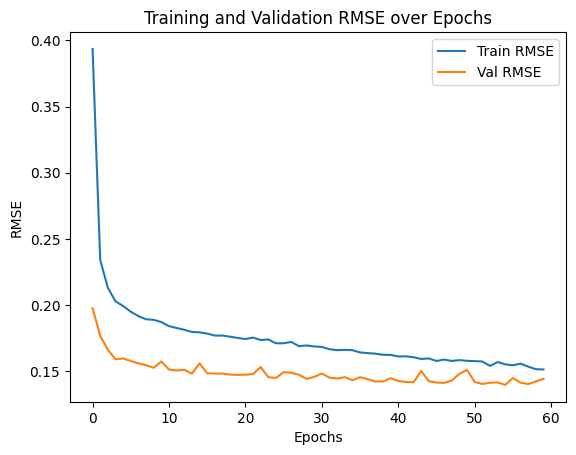

In [ ]:
plt.plot(range(0, EPOCHS), history["train_rmse"], label="Train RMSE")
plt.plot(range(0, EPOCHS), history["val_rmse"], label="Val RMSE")
plt.xlabel("Epochs")
plt.ylabel("RMSE")
plt.legend()
plt.title("Training and Validation RMSE over Epochs")
plt.show()

Text(4, 4.2, 'R2:0.925')

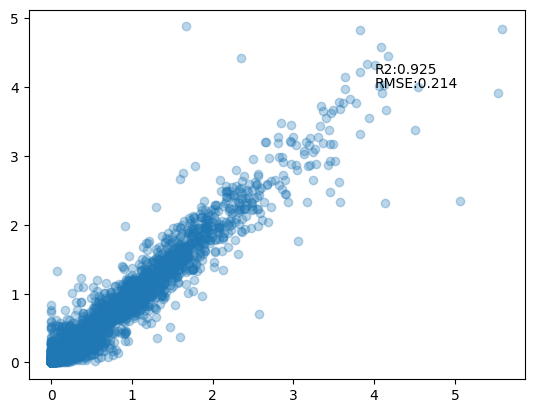

In [ ]:
# next day prediction performance
rmse = root_mean_squared_error(utils.clip_and_inverse_log2_transform(actuals), utils.clip_and_inverse_log2_transform(preds))
r2 = r2_score(utils.clip_and_inverse_log2_transform(actuals), utils.clip_and_inverse_log2_transform(preds))

plt.scatter(utils.clip_and_inverse_log2_transform(actuals), utils.clip_and_inverse_log2_transform(preds), alpha=0.3)
plt.text(x=4, y = 4, s = f"RMSE:{rmse:.3f}")
plt.text(x= 4, y = 4.2, s=f"R2:{r2:.3f}")



In [ ]:
y_pred_val_at, y_val_at = utils.compute_recursive_predictions_fast_torch(model_best, val_df_at, feature_window_size=lag_n,
label_window_size=1, shift=1, config=config, batch_size=128)

In [ ]:
rmse_recursive = root_mean_squared_error(utils.clip_and_inverse_log2_transform(y_val_at), utils.clip_and_inverse_log2_transform(y_pred_val_at))
r2_recursive = r2_score(utils.clip_and_inverse_log2_transform(y_val_at), utils.clip_and_inverse_log2_transform(y_pred_val_at))
print(f"Recursive prediction on validation set - RMSE: {rmse_recursive:.4f}, R2: {r2_recursive:.4f}")

Recursive prediction on validation set - RMSE: 0.4931, R2: 0.6203


In [153]:
# !cd eth-capstone-treewater-deficit/ && git status && git add -all && git commit -m "Transformer output added" && git push origin transformer_colab

NameError: name 'rmses_cv_at' is not defined

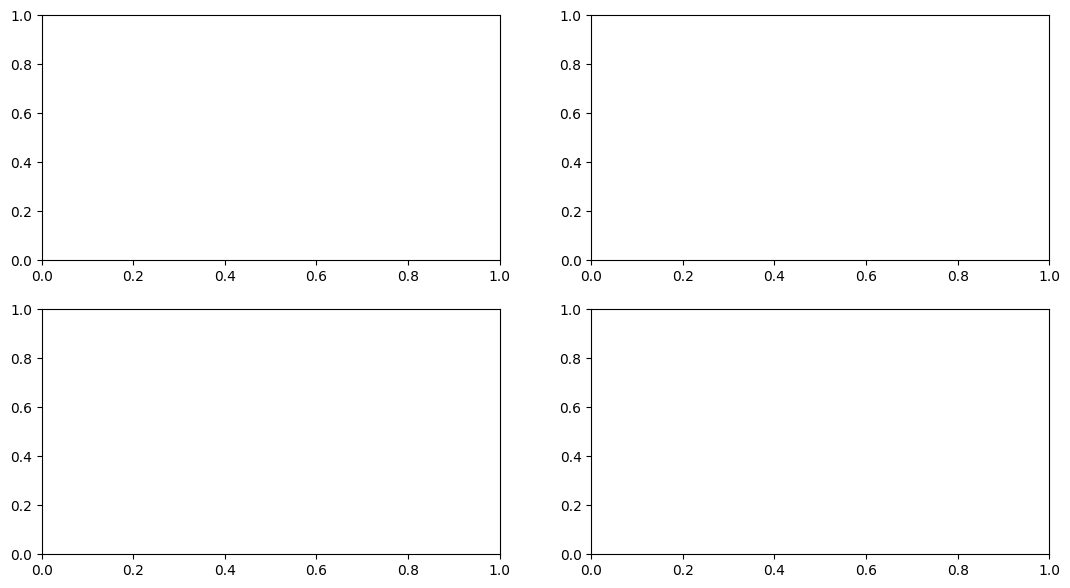

In [17]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(13, 7))

ax1.bar(np.arange(0.75,4.75, 1), rmses_cv_at, color='tab:orange', width = 0.4)
ax1.bar(np.arange(1.25,5.25,1),rmses_cv_at2, color = "tab:blue", width = 0.4)

ax1.set_xticks(range(1,5))
ax1.legend(['hidden size =16', 'hidden size =32'])
ax1.set_ylabel('RMSE - AR')
ax1.set_xlabel("CV fold")
ax1.set_title("RMSE - AR")
# rmses_cv_at


ax2.bar(np.arange(0.75, 4.75, 1), r2s_cv_at, color='tab:orange', width = 0.4)
ax2.bar(np.arange(1.25,5.25,1),r2s_cv_at2, color = "tab:blue", width = 0.4)
ax2.set_xticks(range(1,5))
ax2.legend(['hidden size =16', 'hidden size =32'])
ax2.set_ylabel('R2 - AR')
ax2.set_xlabel("CV fold")
ax2.set_title("R2 - AR")   


ax3.bar([1,2],  [np.mean(rmses_cv_at), np.mean(rmses_cv_at2)],
       color=['tab:orange', 'tab:blue'], width = 0.4)
ax3.errorbar(x = [1,2], y = [np.mean(rmses_cv_at), np.mean(rmses_cv_at2)], 
             yerr=[np.std(rmses_cv_at), np.std(rmses_cv_at2)],
             fmt='.', color='Black', elinewidth=2,capthick=10,errorevery=1)
ax3.set_xticks([1,2])
ax3.set_xticklabels(['hidden size =16', 'hidden size =32'])


ax4.bar([1,2],  [np.mean(r2s_cv_at), np.mean(r2s_cv_at2)],
       color=['tab:orange', 'tab:blue'], width = 0.4)
ax4.errorbar(x = [1,2], y = [np.mean(r2s_cv_at), np.mean(r2s_cv_at2)], 
             yerr=[np.std(r2s_cv_at), np.std(r2s_cv_at2)],
             fmt='.', color='Black', elinewidth=2,capthick=10,errorevery=1)
ax4.set_xticks([1,2])
ax4.set_xticklabels(['hidden size =16', 'hidden size =32'])
             

- performance appears more stable when hidden space dimension is 32 

In [39]:
hidden_unit_size = 32

In [40]:
model_at = build_autoregressive_model_lstm(train_X_ts_at, train_day_feat_X_at, train_static_X_ts_at, lag_n, hidden_unit = hidden_unit_size)
history_at = model_at.fit(
    train_ds_at,
    epochs=50,
    validation_data=val_ds_at,
)


Epoch 1/50


238/238 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.2689 - mae: 0.2586 - rmse: 0.3773 - val_loss: 0.1649 - val_mae: 0.1553 - val_rmse: 0.2222
Epoch 2/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1590 - mae: 0.1499 - rmse: 0.2258 - val_loss: 0.1344 - val_mae: 0.1259 - val_rmse: 0.1911
Epoch 3/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1360 - mae: 0.1280 - rmse: 0.2024 - val_loss: 0.1220 - val_mae: 0.1144 - val_rmse: 0.1755
Epoch 4/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1257 - mae: 0.1185 - rmse: 0.1924 - val_loss: 0.1166 - val_mae: 0.1097 - val_rmse: 0.1707
Epoch 5/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1172 - mae: 0.1106 - rmse: 0.1846 - val_loss: 0.1089 - val_mae: 0.1027 - val_rmse: 0.1658
Epoch 6/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1117 - mae: 0.1058 - rmse: 0.1795 - val_loss: 0.1028 - val_mae: 0.0971 - val_rmse: 0.1618
Epoch 7/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1073 - mae: 0.1018 - rmse: 0.1757 - v

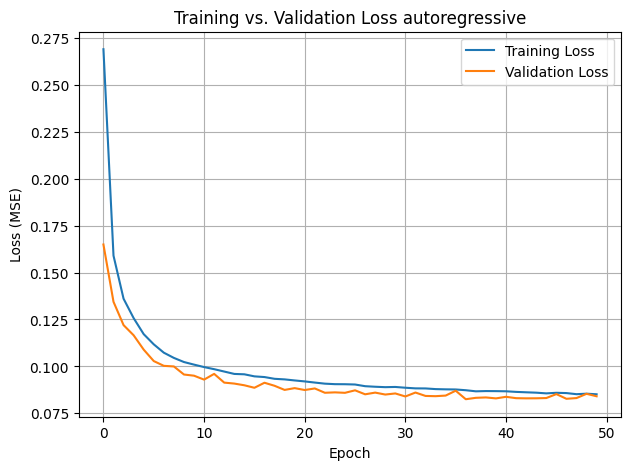

51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
rmse: 0.182948, r2: 0.945363 


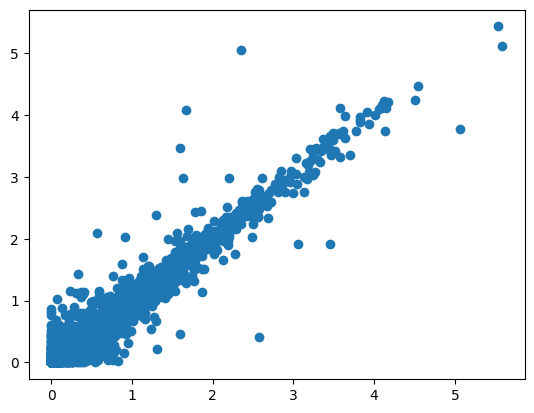

In [41]:


# Extract loss values
train_loss_at= history_at.history["loss"]
val_loss_at = history_at.history["val_loss"]

# Plot
plt.figure(figsize=(7, 5))
plt.plot(train_loss_at, label="Training Loss")
plt.plot(val_loss_at, label="Validation Loss")
plt.title("Training vs. Validation Loss autoregressive")
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.legend()
plt.grid(True)
plt.show()




y_pred_val_1day_at= model_at.predict(val_ds_at)# show first few predictions

rmse_1day_at = root_mean_squared_error(clip_and_inverse_log2_transform(y_pred_val_1day_at), clip_and_inverse_log2_transform(val_y_at))
r2_1day_at = r2_score(clip_and_inverse_log2_transform(val_y_at), clip_and_inverse_log2_transform(y_pred_val_1day_at))
print(f'rmse: {rmse_1day_at:3f}, r2: {r2_1day_at:3f} ')
plt.scatter(clip_and_inverse_log2_transform(val_y_at), clip_and_inverse_log2_transform(y_pred_val_1day_at))

In [42]:
#sanity check on the newly built function with ridge regression, the prediction is the same from the other function
y_pred_val_at, y_val_at = compute_recursive_predictions_fast_LSTM(model_at, val_df_at, feature_window_size=lag_n,
label_window_size=1, shift=1, config=config, batch_size=64)

In [43]:
r2_at = r2_score(clip_and_inverse_log2_transform(y_val_at), clip_and_inverse_log2_transform(y_pred_val_at))
rmse_at = root_mean_squared_error(clip_and_inverse_log2_transform(y_val_at), clip_and_inverse_log2_transform(y_pred_val_at))

print(f"r2: {r2_at}\n rmse: {rmse_at}")

r2: 0.6802166528134933
 rmse: 0.4471958190586472


add cross-validation

In [ ]:
# build a fresh model with identical architecture
model_ar = build_autoregressive_model_lstm(
    train_X_ts_at,
    train_day_feat_X_at,
    train_static_X_ts_at,
    lag_n=lag_n,
    hidden_unit=hidden_unit_size,
)

# copy weights from model_at (teacher-forced trained model)
model_ar.set_weights(model_at.get_weights())

# fine tune the model within CV

maes_cv_at_finetune, rmses_cv_at_finetune, rmses_cv_1d_at_finetune, r2s_cv_1d_at_finetune, \
r2s_cv_at_finetune, y_preds_cv_at_finetune, y_trues_cv_at_finetune, historys_cv_at_finetune = cross_validation_LSTM_FT(
    model_ar,
    train_val_datasets_at = train_val_datasets_at,
    lag_n = lag_n,
    config = config,
    num_epochs=50,
    batch_size = batch_size
)



Training fold 1/4
Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.2173 - mae: 0.2166 - rmse: 0.3143 - val_loss: 0.1486 - val_mae: 0.1479 - val_rmse: 0.1980
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2077 - mae: 0.2070 - rmse: 0.2999 - val_loss: 0.1490 - val_mae: 0.1483 - val_rmse: 0.2017
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1993 - mae: 0.1986 - rmse: 0.2928 - val_loss: 0.1477 - val_mae: 0.1471 - val_rmse: 0.2042
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1966 - mae: 0.1959 - rmse: 0.2904 - val_loss: 0.1462 - val_mae: 0.1456 - val_rmse: 0.2040
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1926 - mae: 0.1919 - rmse: 0.2868 - val_loss: 0.1424 - val_mae: 0.1418 - val_rmse: 0.2006
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1908 - mae: 0.1901 - rmse: 0.2843 - val_loss: 0.1406 - val_mae: 0.1399 - val_rmse: 0.1993
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1887 - mae: 0.1880 - 

In [ ]:
X_dyn_ar, X_day_ar, X_static_ar, y_ar = build_autoregressive_training_data_fast_LSTM(
    model=model_at,
    df=train_df_at,
    feature_window_size=lag_n,
    label_window_size=1,
    shift=1,
    config=config,
    batch_size=64,
)

ds_ar = tf.data.Dataset.from_tensor_slices(
    ((X_dyn_ar, X_day_ar, X_static_ar), y_ar)
).batch(64).prefetch(tf.data.AUTOTUNE)

In [ ]:
# train final model on the full training set with AR-corrupted data
E2 = 50

# build a fresh model with identical architecture
model_ar = build_autoregressive_model_lstm(
    train_X_ts_at,
    train_day_feat_X_at,
    train_static_X_ts_at,
    lag_n=lag_n,
    hidden_unit=hidden_unit_size,
)

# copy weights from model_at (teacher-forced trained model)
model_ar.set_weights(model_at.get_weights())

# now fine-tune on AR-corrupted dataset
model_ar.fit(
    ds_ar,
    epochs=E2,
    validation_data=val_ds_at
)


Epoch 1/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0880 - mae: 0.2148 - rmse: 0.2960 - val_loss: 0.0296 - val_mae: 0.1248 - val_rmse: 0.1711
Epoch 2/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0877 - mae: 0.2148 - rmse: 0.2955 - val_loss: 0.0318 - val_mae: 0.1310 - val_rmse: 0.1773
Epoch 3/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0868 - mae: 0.2128 - rmse: 0.2939 - val_loss: 0.0327 - val_mae: 0.1331 - val_rmse: 0.1797
Epoch 4/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0861 - mae: 0.2115 - rmse: 0.2927 - val_loss: 0.0343 - val_mae: 0.1375 - val_rmse: 0.1841
Epoch 5/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0856 - mae: 0.2106 - rmse: 0.2917 - val_loss: 0.0348 - val_mae: 0.1392 - val_rmse: 0.1855
Epoch 6/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0851 - mae: 0.2099 - rmse: 0.2909 - val_loss: 0.0360 - val_mae: 0.1422 - val_rmse: 0.1886
Epoch 7/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0847 - mae: 0.2094 - rmse:

In [ ]:
#sanity check on the newly built function with ridge regression, the prediction is the same from the other function
y_pred_val_at_FT, y_val_at_FT = compute_recursive_predictions_fast_LSTM(model_ar, val_df_at, feature_window_size=lag_n,
label_window_size=1, shift=1, config=config, batch_size=64)

In [ ]:
r2_FT = r2_score(clip_and_inverse_log2_transform(y_val_at_FT), clip_and_inverse_log2_transform(y_pred_val_at_FT))
rmse_FT = root_mean_squared_error(clip_and_inverse_log2_transform(y_val_at_FT), clip_and_inverse_log2_transform(y_pred_val_at_FT))

print(f"r2: {r2_FT}\n rmse: {rmse_FT}")

r2: 0.027230332635112098
 rmse: 0.7799644754899039


### scheduled sampling - train model

cross validation - implement cross validation

In [ ]:
num_epochs = 45

# init model with same architecture
model_at_ar_cv = build_autoregressive_model_lstm(
    train_X_ts_at,
    train_day_feat_X_at,
    train_static_X_ts_at,
    lag_n=lag_n,
    hidden_unit=hidden_unit_size,
)
# copy weights from model_at (teacher-forced trained model)
model_at_ar_cv.set_weights(model_at.get_weights())

maes_cv_at_ar, rmses_cv_at_ar, rmses_cv_1d_at_ar, r2s_cv_1d_at_ar, \
r2s_cv_at_ar, y_preds_cv_at_ar, y_trues_cv_at_ar, historys_cv_at_ar = cross_validation_LSTM_AR(
    model_at_ar_cv,
    train_val_datasets_at = train_val_datasets_at,
    lag_n = lag_n,
    config = config,
    num_epochs=num_epochs,
    batch_size = batch_size,
    p_min = 0.1,
    warmup_epochs=3,
    frac_decay=0.9,
    slow_decay=True)




Training fold 1/4
Epoch 1/45 - loss: 0.0215 - rmse: 0.1454 - val_loss: 0.0587 - val_rmse: 0.2425 - p_tf: 1.000
Epoch 2/45 - loss: 0.0196 - rmse: 0.1383 - val_loss: 0.0451 - val_rmse: 0.2123 - p_tf: 1.000
Epoch 3/45 - loss: 0.0193 - rmse: 0.1377 - val_loss: 0.0521 - val_rmse: 0.2285 - p_tf: 1.000
Epoch 4/45 - loss: 0.0202 - rmse: 0.1411 - val_loss: 0.0413 - val_rmse: 0.2031 - p_tf: 0.871
Epoch 5/45 - loss: 0.0201 - rmse: 0.1404 - val_loss: 0.0466 - val_rmse: 0.2158 - p_tf: 0.871
Epoch 6/45 - loss: 0.0197 - rmse: 0.1389 - val_loss: 0.0449 - val_rmse: 0.2119 - p_tf: 0.871
Epoch 7/45 - loss: 0.0197 - rmse: 0.1388 - val_loss: 0.0410 - val_rmse: 0.2025 - p_tf: 0.871
Epoch 8/45 - loss: 0.0193 - rmse: 0.1375 - val_loss: 0.0386 - val_rmse: 0.1964 - p_tf: 0.871
Epoch 9/45 - loss: 0.0209 - rmse: 0.1430 - val_loss: 0.0425 - val_rmse: 0.2060 - p_tf: 0.743
Epoch 10/45 - loss: 0.0205 - rmse: 0.1416 - val_loss: 0.0374 - val_rmse: 0.1931 - p_tf: 0.743
Epoch 11/45 - loss: 0.0199 - rmse: 0.1396 - val_los

2025-12-29 20:01:16.963952: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 16/45 - loss: 0.0229 - rmse: 0.1503 - val_loss: 0.0448 - val_rmse: 0.2116 - p_tf: 0.614
Epoch 17/45 - loss: 0.0217 - rmse: 0.1462 - val_loss: 0.0619 - val_rmse: 0.2490 - p_tf: 0.614
Epoch 18/45 - loss: 0.0227 - rmse: 0.1490 - val_loss: 0.0548 - val_rmse: 0.2344 - p_tf: 0.614
Epoch 19/45 - loss: 0.0246 - rmse: 0.1558 - val_loss: 0.0548 - val_rmse: 0.2343 - p_tf: 0.486
Epoch 20/45 - loss: 0.0291 - rmse: 0.1691 - val_loss: 0.0669 - val_rmse: 0.2591 - p_tf: 0.486
Epoch 21/45 - loss: 0.0284 - rmse: 0.1675 - val_loss: 0.0489 - val_rmse: 0.2213 - p_tf: 0.486
Epoch 22/45 - loss: 0.0256 - rmse: 0.1589 - val_loss: 0.0617 - val_rmse: 0.2486 - p_tf: 0.486
Epoch 23/45 - loss: 0.0257 - rmse: 0.1593 - val_loss: 0.0572 - val_rmse: 0.2395 - p_tf: 0.486
Epoch 24/45 - loss: 0.0288 - rmse: 0.1686 - val_loss: 0.0605 - val_rmse: 0.2463 - p_tf: 0.357
Epoch 25/45 - loss: 0.0299 - rmse: 0.1720 - val_loss: 0.0675 - val_rmse: 0.2603 - p_tf: 0.357
Epoch 26/45 - loss: 0.0331 - rmse: 0.1809 - val_loss: 0.0741

2025-12-29 20:10:04.485376: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 3/45 - loss: 0.0235 - rmse: 0.1509 - val_loss: 0.0563 - val_rmse: 0.2361 - p_tf: 1.000
Epoch 4/45 - loss: 0.0244 - rmse: 0.1538 - val_loss: 0.0517 - val_rmse: 0.2261 - p_tf: 0.871
Epoch 5/45 - loss: 0.0234 - rmse: 0.1507 - val_loss: 0.0507 - val_rmse: 0.2240 - p_tf: 0.871
Epoch 6/45 - loss: 0.0226 - rmse: 0.1479 - val_loss: 0.0490 - val_rmse: 0.2202 - p_tf: 0.871
Epoch 7/45 - loss: 0.0220 - rmse: 0.1462 - val_loss: 0.0519 - val_rmse: 0.2267 - p_tf: 0.871
Epoch 8/45 - loss: 0.0214 - rmse: 0.1440 - val_loss: 0.0467 - val_rmse: 0.2149 - p_tf: 0.871
Epoch 9/45 - loss: 0.0238 - rmse: 0.1524 - val_loss: 0.0468 - val_rmse: 0.2153 - p_tf: 0.743
Epoch 10/45 - loss: 0.0235 - rmse: 0.1513 - val_loss: 0.0468 - val_rmse: 0.2153 - p_tf: 0.743
Epoch 11/45 - loss: 0.0236 - rmse: 0.1515 - val_loss: 0.0483 - val_rmse: 0.2187 - p_tf: 0.743
Epoch 12/45 - loss: 0.0231 - rmse: 0.1500 - val_loss: 0.0472 - val_rmse: 0.2162 - p_tf: 0.743
Epoch 13/45 - loss: 0.0231 - rmse: 0.1501 - val_loss: 0.0464 - val_

2025-12-29 20:33:30.621910: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 21/45 - loss: 0.0324 - rmse: 0.1786 - val_loss: 0.0223 - val_rmse: 0.1482 - p_tf: 0.486
Epoch 22/45 - loss: 0.0314 - rmse: 0.1755 - val_loss: 0.0215 - val_rmse: 0.1454 - p_tf: 0.486
Epoch 23/45 - loss: 0.0312 - rmse: 0.1751 - val_loss: 0.0216 - val_rmse: 0.1457 - p_tf: 0.486
Epoch 24/45 - loss: 0.0358 - rmse: 0.1876 - val_loss: 0.0221 - val_rmse: 0.1475 - p_tf: 0.357
Epoch 25/45 - loss: 0.0364 - rmse: 0.1896 - val_loss: 0.0213 - val_rmse: 0.1447 - p_tf: 0.357
Epoch 26/45 - loss: 0.0356 - rmse: 0.1873 - val_loss: 0.0221 - val_rmse: 0.1474 - p_tf: 0.357
Epoch 27/45 - loss: 0.0372 - rmse: 0.1916 - val_loss: 0.0217 - val_rmse: 0.1460 - p_tf: 0.357
Epoch 28/45 - loss: 0.0361 - rmse: 0.1885 - val_loss: 0.0238 - val_rmse: 0.1533 - p_tf: 0.357
Epoch 29/45 - loss: 0.0484 - rmse: 0.2189 - val_loss: 0.0258 - val_rmse: 0.1595 - p_tf: 0.229
Epoch 30/45 - loss: 0.0550 - rmse: 0.2330 - val_loss: 0.0455 - val_rmse: 0.2129 - p_tf: 0.229
Epoch 31/45 - loss: 0.0655 - rmse: 0.2550 - val_loss: 0.0467

- more epochs, decay slower, stepwise training 
- hidden size 16, shorter window

In [ ]:
# now do scheduled sampling training on the full training set
num_epochs = 120

history_ar_at = {
"loss": [],
"rmse": [],
"val_loss": [],
"val_rmse": [],
"p_tf": []
}


# init model with same architecture
model_at_ar = build_autoregressive_model_lstm(
    train_X_ts_at,
    train_day_feat_X_at,
    train_static_X_ts_at,
    lag_n=lag_n,
    hidden_unit=hidden_unit_size,
)
# copy weights from model_at (teacher-forced trained model)
model_at_ar.set_weights(model_at.get_weights())



for epoch in range(num_epochs):
        # train model with teacher forcing for the first epoch 
    p_tf = teacher_forcing_prob_stepwise(epoch, num_epochs,epoch_per_step=15, step_size=0.1, p0=1.0, p_min=0.1, warmup_epochs=3, frac_decay=0.9)
    history_ar_at["p_tf"].append(p_tf)

    # rebuild AR / scheduled-sampling training data
    X_dyn_ar_at, X_day_ar_at, X_static_ar_at, y_ar_at = build_autoregressive_training_data_fast_LSTM_scheduled(
        model_at_ar,
        train_df_at,
        feature_window_size=lag_n,
        label_window_size=1,
        shift=1,
        config=config,
        batch_size=batch_size,
        teacher_forcing_prob=p_tf,
    )

    train_ds_at_decay = (
        tf.data.Dataset.from_tensor_slices(((X_dyn_ar_at, X_day_ar_at, X_static_ar_at), y_ar_at))
        .shuffle(len(X_dyn_ar_at))
        .batch(batch_size)
        .prefetch(tf.data.AUTOTUNE)
    )

    # one epoch of manual training
    epoch_loss = tf.keras.metrics.Mean()
    epoch_rmse = tf.keras.metrics.RootMeanSquaredError()

    for (x_dyn, x_day, x_stat), y in train_ds_at_decay:
        with tf.GradientTape() as tape:
            preds = model_at_ar([x_dyn, x_day, x_stat], training=True)
            loss = model_at_ar.compute_loss(x=None, y=y, y_pred=preds, sample_weight=None, training=True)

        grads = tape.gradient(loss, model_at_ar.trainable_variables)
        model_at_ar.optimizer.apply_gradients(zip(grads, model_at_ar.trainable_variables))      
        epoch_loss.update_state(loss)
        epoch_rmse.update_state(y, preds)

    # validation
    val_loss_metric = tf.keras.metrics.Mean()
    val_rmse_metric = tf.keras.metrics.RootMeanSquaredError()
    for (x_dyn_v, x_day_v, x_stat_v), y_v in val_ds_at:
        preds_v = model_at_ar([x_dyn_v, x_day_v, x_stat_v], training=False)
        v_loss = model_at_ar.compute_loss(x=None, y=y_v, y_pred=preds_v, sample_weight=None, training=False)
        val_loss_metric.update_state(v_loss)
        val_rmse_metric.update_state(y_v, preds_v)

    history_ar_at["loss"].append(epoch_loss.result().numpy())
    history_ar_at["rmse"].append(epoch_rmse.result().numpy())
    history_ar_at["val_loss"].append(val_loss_metric.result().numpy())
    history_ar_at["val_rmse"].append(val_rmse_metric.result().numpy())
    history_ar_at["p_tf"].append(p_tf)

    print(
        f"Epoch {epoch+1}/{num_epochs} - "
        f"loss: {history_ar_at['loss'][-1]:.4f} - rmse: {history_ar_at['rmse'][-1]:.4f} - "
        f"val_loss: {history_ar_at['val_loss'][-1]:.4f} - val_rmse: {history_ar_at['val_rmse'][-1]:.4f} - "
        f"p_tf: {p_tf:.3f}"
    )

Epoch 1/120 - loss: 0.0212 - rmse: 0.1443 - val_loss: 0.0211 - val_rmse: 0.1440 - p_tf: 1.000
Epoch 2/120 - loss: 0.0210 - rmse: 0.1435 - val_loss: 0.0205 - val_rmse: 0.1419 - p_tf: 1.000
Epoch 3/120 - loss: 0.0212 - rmse: 0.1441 - val_loss: 0.0202 - val_rmse: 0.1408 - p_tf: 1.000
Epoch 4/120 - loss: 0.0232 - rmse: 0.1511 - val_loss: 0.0209 - val_rmse: 0.1432 - p_tf: 0.871
Epoch 5/120 - loss: 0.0235 - rmse: 0.1520 - val_loss: 0.0199 - val_rmse: 0.1397 - p_tf: 0.871
Epoch 6/120 - loss: 0.0231 - rmse: 0.1506 - val_loss: 0.0203 - val_rmse: 0.1411 - p_tf: 0.871
Epoch 7/120 - loss: 0.0231 - rmse: 0.1506 - val_loss: 0.0205 - val_rmse: 0.1419 - p_tf: 0.871
Epoch 8/120 - loss: 0.0232 - rmse: 0.1512 - val_loss: 0.0201 - val_rmse: 0.1403 - p_tf: 0.871
Epoch 9/120 - loss: 0.0230 - rmse: 0.1503 - val_loss: 0.0223 - val_rmse: 0.1481 - p_tf: 0.871
Epoch 10/120 - loss: 0.0229 - rmse: 0.1500 - val_loss: 0.0208 - val_rmse: 0.1429 - p_tf: 0.871
Epoch 11/120 - loss: 0.0229 - rmse: 0.1499 - val_loss: 0.02

2025-12-29 21:43:16.614330: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 44/120 - loss: 0.0266 - rmse: 0.1618 - val_loss: 0.0211 - val_rmse: 0.1440 - p_tf: 0.614
Epoch 45/120 - loss: 0.0275 - rmse: 0.1645 - val_loss: 0.0207 - val_rmse: 0.1424 - p_tf: 0.614
Epoch 46/120 - loss: 0.0266 - rmse: 0.1620 - val_loss: 0.0216 - val_rmse: 0.1458 - p_tf: 0.614
Epoch 47/120 - loss: 0.0282 - rmse: 0.1667 - val_loss: 0.0209 - val_rmse: 0.1434 - p_tf: 0.614
Epoch 48/120 - loss: 0.0268 - rmse: 0.1623 - val_loss: 0.0213 - val_rmse: 0.1446 - p_tf: 0.614
Epoch 49/120 - loss: 0.0302 - rmse: 0.1727 - val_loss: 0.0212 - val_rmse: 0.1442 - p_tf: 0.486
Epoch 50/120 - loss: 0.0303 - rmse: 0.1729 - val_loss: 0.0232 - val_rmse: 0.1510 - p_tf: 0.486
Epoch 51/120 - loss: 0.0330 - rmse: 0.1805 - val_loss: 0.0219 - val_rmse: 0.1468 - p_tf: 0.486
Epoch 52/120 - loss: 0.0325 - rmse: 0.1790 - val_loss: 0.0215 - val_rmse: 0.1453 - p_tf: 0.486
Epoch 53/120 - loss: 0.0310 - rmse: 0.1748 - val_loss: 0.0209 - val_rmse: 0.1431 - p_tf: 0.486
Epoch 54/120 - loss: 0.0310 - rmse: 0.1747 - val_l

maybe adjust loss function?

In [ ]:
# save training history
train_his_path = f"/cluster/home/taoj/work_dir/eth-capstone/tree-water-deficit/data/derived/training_history/history_ar_at_LSTM_scheduled_sampling_log.npy"
np.save(train_his_path, history_ar_at)

In [ ]:
#sanity check on the newly built function with ridge regression, the prediction is the same from the other function
y_pred_val_at_ar, y_val_at_ar= compute_recursive_predictions_fast_LSTM(model_at_ar, val_df_at, feature_window_size=lag_n,
label_window_size=1, shift=1, config=config, batch_size=64)
r2_at_ar = r2_score(clip_and_inverse_log2_transform(y_val_at_ar),clip_and_inverse_log2_transform(y_pred_val_at_ar))
rmse_at_ar = root_mean_squared_error(clip_and_inverse_log2_transform(y_val_at_ar), clip_and_inverse_log2_transform(y_pred_val_at_ar))

print(f"r2: {r2_at_ar}\n rmse: {rmse_at_ar}")

r2: 0.18266580596301996
 rmse: 0.7149400836851747


In [ ]:
# plot performance together

df_model_performance = pd.DataFrame({
    "model" :['teacher_forcing (hidden=16)'] *4 + ['teacher_forcing (hidden=32)'] *4 + ['fine_tuned (hidden=16)'] *4 + ['scheduled_sampling (hidden=16)'] *4,    
    "cv_fold"  : [i for i in range(1, len(maes_cv_at_ar) + 1)] *4,
    "mae": maes_cv_at + maes_cv_at2 + maes_cv_at_finetune + maes_cv_at_ar,
    "rmse_recursive": rmses_cv_at + rmses_cv_at2 + rmses_cv_at_finetune + rmses_cv_at_ar,
    "rmse_1day": rmses_cv_1d_at + rmses_cv_1d_at2 + rmses_cv_1d_at_finetune + rmses_cv_1d_at_ar,
    "r2_1day" : r2s_cv_1d_at + r2s_cv_1d_at2 + r2s_cv_1d_at_finetune + r2s_cv_1d_at_ar,
    "r2_recursive": r2s_cv_at + r2s_cv_at2 + r2s_cv_at_finetune + r2s_cv_at_ar,
}
)

df_model_p_long = df_model_performance.melt(id_vars=["model", "cv_fold"], 
                                        value_vars=["mae", "rmse_recursive", "rmse_1day", "r2_1day", "r2_recursive"],
                                        var_name="metric",
                                        value_name="value"
                                        )

In [ ]:
df_model_p_long.loc[df_model_p_long.metric == "r2_recursive",]

,model,cv_fold,metric,value
64,teacher_forcing (hidden=16),1,r2_recursive,-1.699413
65,teacher_forcing (hidden=16),2,r2_recursive,0.498372
66,teacher_forcing (hidden=16),3,r2_recursive,0.330853
67,teacher_forcing (hidden=16),4,r2_recursive,-0.077144
68,teacher_forcing (hidden=32),1,r2_recursive,-0.209858
69,teacher_forcing (hidden=32),2,r2_recursive,0.062481
70,teacher_forcing (hidden=32),3,r2_recursive,0.118385
71,teacher_forcing (hidden=32),4,r2_recursive,-0.018747
72,fine_tuned (hidden=16),1,r2_recursive,-0.003637
73,fine_tuned (hidden=16),2,r2_recursive,0.393070


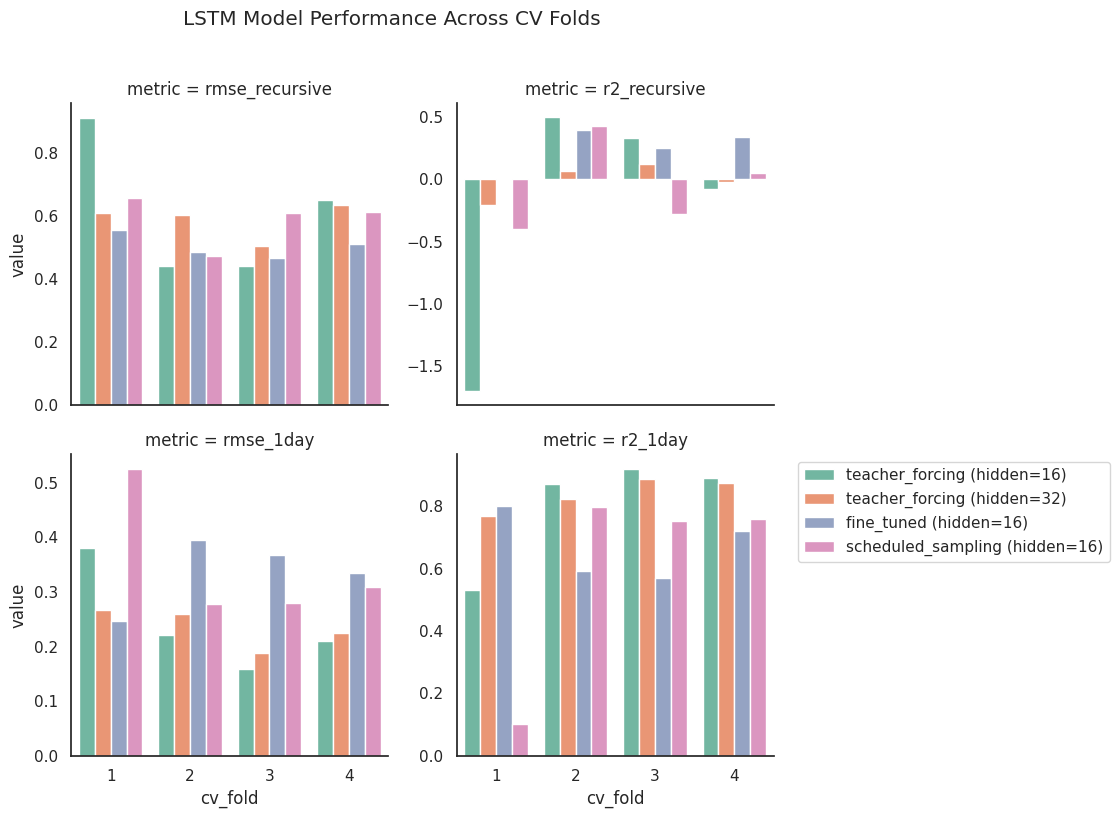

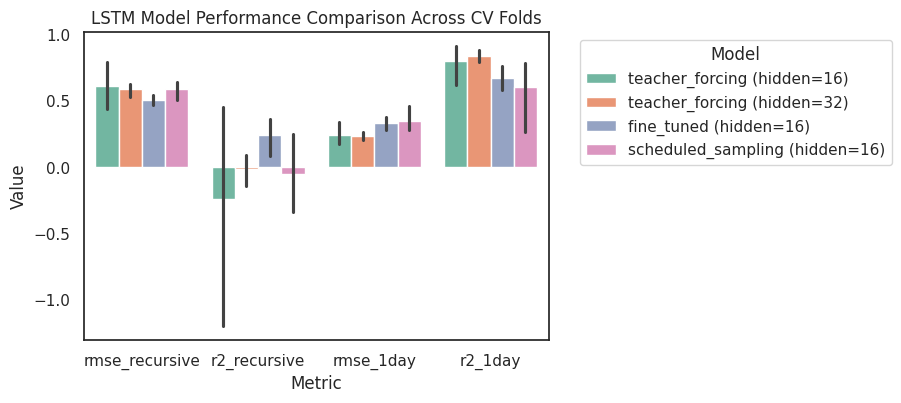

In [ ]:
sns.set(style="white", font_scale=1,
        rc={"figure.figsize": (6, 4)})

metrics_plot = ['rmse_recursive', 'r2_recursive', 'rmse_1day', 'r2_1day']
df_p_plot = df_model_p_long.loc[df_model_p_long['metric'].isin(
metrics_plot
)]  
g = sns.FacetGrid(df_p_plot, col="metric", col_wrap = 2,
              col_order = metrics_plot,
              height=4, sharey=False).map_dataframe(
    sns.barplot,
    x="cv_fold",
    y="value",
    hue = 'model',
    palette = "Set2",
    legend = True,
)

g.figure.suptitle("LSTM Model Performance Across CV Folds", y=1.02)


plt.tight_layout()
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()

sns.barplot(df_p_plot, x="metric", y="value", hue="model", palette="Set2",
            order = metrics_plot)
plt.title("LSTM Model Performance Comparison Across CV Folds")
plt.xlabel("Metric")
plt.ylabel("Value")
plt.legend(title="Model", bbox_to_anchor=(1.05, 1))
plt.show()


/scratch/tmp.52852127.taoj/ipykernel_1590048/3687270685.py:19: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax1.plot(x_range, x_range, 'k--', lw=2, color="tab:orange")
/scratch/tmp.52852127.taoj/ipykernel_1590048/3687270685.py:20: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax1.plot(x_range, [i+rmse_at for i in x_range], 'k--', lw=2, color="gold")
/scratch/tmp.52852127.taoj/ipykernel_1590048/3687270685.py:21: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax1.plot(x_range, [i-rmse_at for i in x_range], 'k--', lw=2, color="gold")
/scratch/tmp.52852127.taoj/ipykernel_1590048/3687270685.py:34: UserWarning: color is redundantly defined by the 'color' k

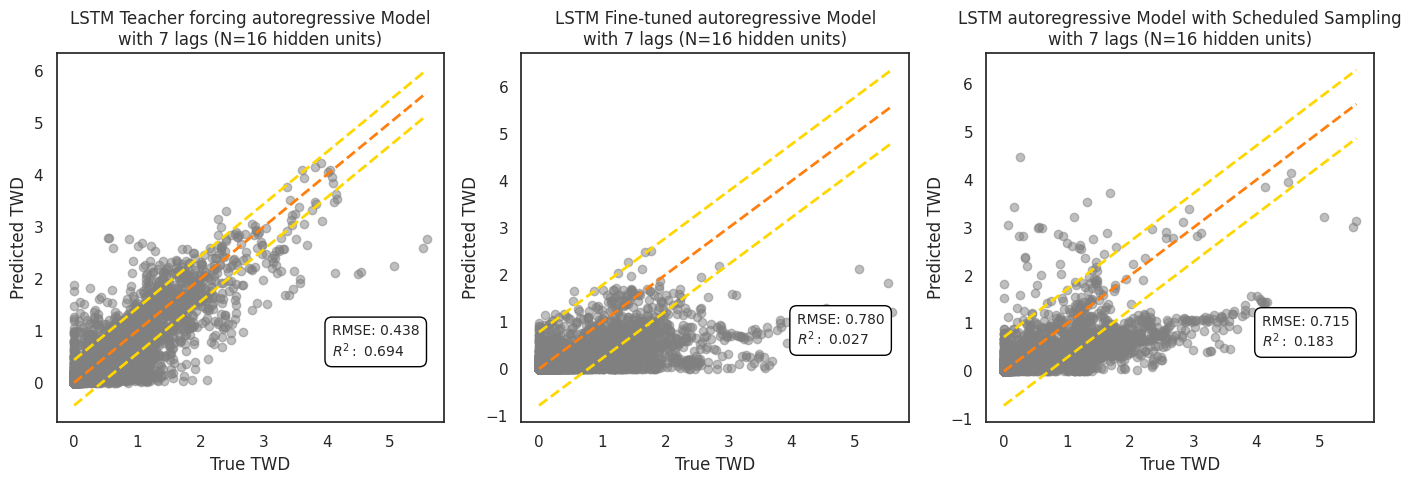

In [ ]:
# Create figure with 3 subplots showing model final performance

def ensure_numpy(x):
    if isinstance(x, tf.Tensor):
        return x.numpy()
    return np.asarray(x)
y_val_at = clip_and_inverse_log2_transform(ensure_numpy(y_val_at).reshape(-1))
y_pred_val_at = clip_and_inverse_log2_transform(ensure_numpy(y_pred_val_at).reshape(-1))
# val_y = ensure_numpy(val_y)

fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize=(14, 5))


# First subplot - Autoregressive Model Predictions hidden 32
ax1.scatter(x=y_val_at, y=y_pred_val_at, color="grey", alpha=0.5)
ax1.set_xlabel("True TWD")
ax1.set_ylabel("Predicted TWD")
x_range = [y_val_at.min(), y_val_at.max()]
ax1.plot(x_range, x_range, 'k--', lw=2, color="tab:orange")
ax1.plot(x_range, [i+rmse_at for i in x_range], 'k--', lw=2, color="gold")
ax1.plot(x_range, [i-rmse_at for i in x_range], 'k--', lw=2, color="gold")
ax1.set_title(f"LSTM Teacher forcing autoregressive Model\nwith {lag_n} lags (N=16 hidden units)")
ax1.text(y_val_at.max()-1.5,y_pred_val_at.min()+0.5, 
         f"RMSE: {rmse_at:.3f}\n$R^2:$ {r2_at:.3f}", 
         fontsize=10, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))



# plot fine-tuned 
ax2.scatter(x =  clip_and_inverse_log2_transform(ensure_numpy(y_val_at_FT).reshape(-1)), y = clip_and_inverse_log2_transform(ensure_numpy(y_pred_val_at_FT).reshape(-1)), color="grey", alpha=0.5)
ax2.set_xlabel("True TWD")
ax2.set_ylabel("Predicted TWD")
x_range = [clip_and_inverse_log2_transform(ensure_numpy(y_val_at_FT).reshape(-1)).min(), clip_and_inverse_log2_transform(ensure_numpy(y_val_at_FT).reshape(-1)).max()]
ax2.plot(x_range, x_range, 'k--', lw=2, color="tab:orange")
ax2.plot(x_range, [i+rmse_FT for i in x_range], 'k--', lw=2, color="gold")
ax2.plot(x_range, [i-rmse_FT for i in x_range], 'k--', lw=2, color="gold")
ax2.set_title(f"LSTM Fine-tuned autoregressive Model\nwith {lag_n} lags (N=16 hidden units)")
ax2.text(clip_and_inverse_log2_transform(ensure_numpy(y_val_at_FT).reshape(-1)).max()-1.5,clip_and_inverse_log2_transform(ensure_numpy(y_pred_val_at_FT).reshape(-1)).min()+0.5, 
         f"RMSE: {rmse_FT:.3f}\n$R^2:$ {r2_FT:.3f}", 
         fontsize=10, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))   


# plot scheduled sampling 
ax3.scatter(x = clip_and_inverse_log2_transform(ensure_numpy(y_val_at_ar).reshape(-1)), y = clip_and_inverse_log2_transform(ensure_numpy(y_pred_val_at_ar).reshape(-1)), color="grey", alpha=0.5)
ax3.set_xlabel("True TWD")
ax3.set_ylabel("Predicted TWD")
x_range = [clip_and_inverse_log2_transform(ensure_numpy(y_val_at_ar).reshape(-1)).min(), clip_and_inverse_log2_transform(ensure_numpy(y_val_at_ar).reshape(-1)).max()]
ax3.plot(x_range, x_range, 'k--', lw=2, color="tab:orange")
ax3.plot(x_range, [i+rmse_at_ar for i in x_range], 'k--', lw=2, color="gold")
ax3.plot(x_range, [i-rmse_at_ar for i in x_range], 'k--', lw=2, color="gold")
ax3.set_title(f"LSTM autoregressive Model with Scheduled Sampling\nwith {lag_n} lags (N=16 hidden units)")
ax3.text(clip_and_inverse_log2_transform(ensure_numpy(y_val_at_ar).reshape(-1)).max()-1.5,clip_and_inverse_log2_transform(ensure_numpy(y_pred_val_at_ar).reshape(-1)).min()+0.5, 
         f"RMSE: {rmse_at_ar:.3f}\n$R^2:$ {r2_at_ar:.3f}", 
         fontsize=10, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))  

plt.tight_layout()
plt.show()



- timeseries prediction across timestep 

why the performance is so bad ..
- try the same on ridge regression?

to improve the model performance
- we can try to improve the LSTM architecture 
    -  added softplus - why it lowered the performance? 
    - play with the architecture and hyperparameter
- add also compute the correlation matrix of lagged features with twd
- should I create cross-validation function to choose the tune the model?
- how can i integrate autoregressive training?
- incorporate log value into traning 
- stack layers? 
- how to extrapolate if i use location and other static parameters in the future?
- perturbation to analyze feature importance